# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #9
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, April 7th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Question 1. Separate the Bayesian Irises

The goal of this problem is to introduce you to the idea of classification 
using Bayesian inferences. 

You are given the famous *Fisher flower Iris data set*
which is a  multivariate data set introduced by Sir Ronald Fisher (1936) as an example of discriminant analysis.
The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, you will build a model to predict
the species. 

For this problem only consider two classes: **virginica** and **not-virginica**. 

The iris data can be obtained [here](iris.txt).

Lets $(X, Y )$ be our dataset, where $X=\{\vec{x}_1, \ldots \vec{x}_n\}$ and $\vec{x}_i$ is a 5D vector corresponding to an offset 1 and
the four components explained above. $Y \in \{0,1\}$ are the scalar 
labels of a class. In other words  
the species labels are your $Y$ data (virginica = 0 and virginica=1), and the four features, petal length
and width, sepal length and width, along with the offset, are your $X$ data. 

The goal is to train a classifier, that will predict an unknown class label $\hat{y}$ from a new data point $x$. 

Consider the following glm (logistic model) for the probability of a class:

$$ p(y) = \frac{1}{1+e^{-x^T \beta}} $$

(or $logit(p) = x^T \beta$ in more traditional glm form)

where $\beta$ is a 5D parameter to learn. 

Then given $p$ at a particular data point $x$, we can use a bernoulli likelihood to get 1's and 0's. This should be enough for you to set up your model in pymc3. (Other Hints: also use theano.tensor.exp when you define the inerse logit to go from $\beta$ to $p$, and you might want to set up $p$ as a deterministic explicitly so that pymc3 does the work of giving you the trace).

Use a 60-40 stratified (preserving class membership) split of the dataset into a training set and a test set. ( See the docs for scikit-learn's `train_test_split`).

## Part A: Sampling

1. Choose a prior for $\beta \sim N(0, \sigma^2 I) $ and write down the formula for the normalized posterior $p(\beta| Y,X)$. Since we dont care about regularization here, just use the mostly uninformative value $\sigma = 10$.
2. Find the MAP and mean estimate for the posterior on the training set.
3. Implement a  sampler to sample from this posterior of $\beta$.   Generate samples of $\beta$ and plot the sequence of $\beta$'s  and histograms for each $\beta$ component.
4. Use both the MAP and MEAN estimate of $\beta$, and the posterior distribution of $\beta$, to generate a set of probabilities and a set of posterior distributions respectively, for each data point $x$ in the training set. Plot the posterior against the MAP and MEAN estimate for 2 or 3 of your data points, preferably those with MAP estimates closer to 0.5.

# 1A (1) - Choose a prior for  β∼N(0,σ2I) and write down the formula for the normalized posterior  p(β|Y,X). Since we dont care about regularization here, just use the mostly uninformative value  σ=10.

From the prompt we know that the parameter $\beta$ is as follows:

$$\beta  \sim N(0,\sigma^2I)$$
$$ $$

$$p(\beta|Y,X) = \frac{p(Y,X|\beta)p(\beta)}{p(Y,X)}$$
$$ $$

Calculating the posterior distribution:  

$$ p(\beta|Y,X) = \frac{p(Y,X|\beta)p(\beta)}{\int p(Y,X|\beta)d\beta}$$

$$ $$
$$p(\beta|Y,X) \propto \left [ \prod_{i=1}^{n} \left ( \frac{1}{1+e^{-x_{i}^T \beta}} \right ) ^{y_i} \left (1-\frac{1}{1+e^{-x_{i}^T \beta}} \right )^{(1-y_i)} \right ] * N(0,\sigma^2I)$$

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
%matplotlib inline

# disable warnings for notebook
import warnings
warnings.simplefilter('ignore')

import theano
import theano.tensor as T
import pymc3 as pm
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
from sklearn.cross_validation import train_test_split
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('paper')
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# read in the data and prepare for x and y columns
iris_df = pd.read_csv('iris.txt')
iris_df['class'] = iris_df['class'].str.strip()

# set the 'y' column for our required classification 
iris_df['y'] = np.zeros((iris_df.shape[0], 1))
iris_df['y'][iris_df['class'] != 'Iris-virginica'] = 1

iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,class,y
0,5.1,3.5,1.4,0.2,Iris-setosa,1.0
1,4.9,3.0,1.4,0.2,Iris-setosa,1.0
2,4.7,3.2,1.3,0.2,Iris-setosa,1.0
3,4.6,3.1,1.5,0.2,Iris-setosa,1.0
4,5.0,3.6,1.4,0.2,Iris-setosa,1.0


# 1A (3) - Implement a sampler to sample from this posterior of  β . Generate samples of  β  and plot the sequence of  β 's and histograms for each  β  component.

In [2]:
# get the predictors
x_preds = np.array(iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values)
x = np.concatenate([np.ones((iris_df.shape[0], 1)), x_preds], axis=1)
y = iris_df['y'].values

# split the predictors into test and train sets - 60/40 split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0, stratify=y)

with pm.Model() as model:
    
    # beta 5 element vector 
    beta = pm.Normal('beta', mu=0, sd=10, shape=5) 
    
    # Logit
    p = pm.Deterministic('p', 1/(1 + T.exp(-T.dot(X_train,beta))))
    
    # define the Likelihood
    likelihood = pm.Bernoulli("likelihood", p, observed=y_train)
    
with model:
    step = pm.NUTS()
    trace = pm.sample(10000, step, progressbar=True)

100%|██████████| 10000/10000 [01:32<00:00, 107.76it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10550d2e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a965fd0>]], dtype=object)

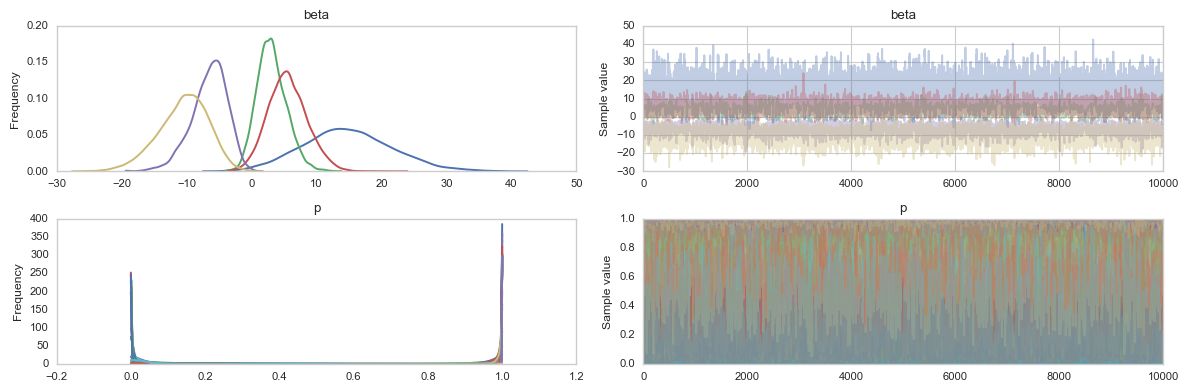

In [3]:
pm.traceplot(trace)

# plot β from all 10,000 traces: 

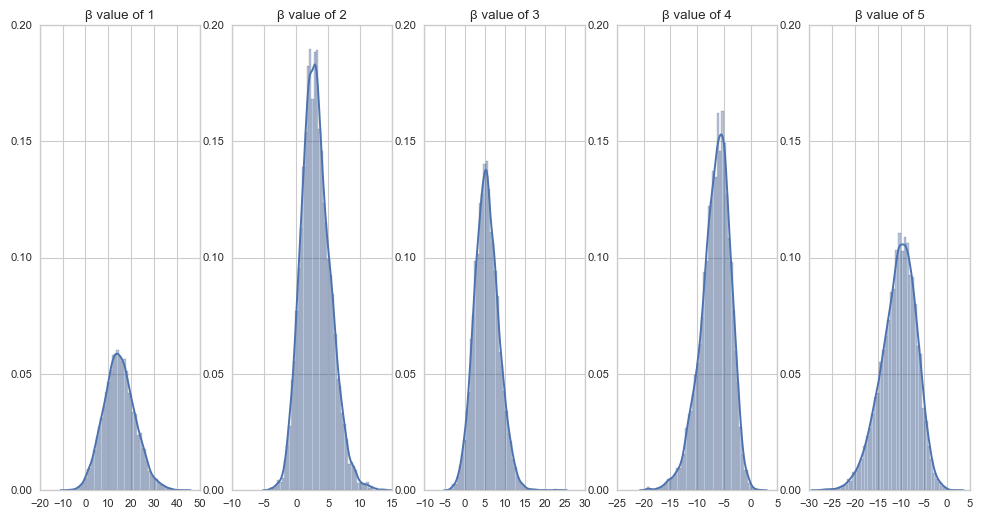

In [4]:
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.title('β value of {}'.format(i+1))
    ax = sns.distplot(trace['beta'][:,i])
    ax.set(ylim=(0, 0.2))

# 1A (2) - Find the MAP and mean estimate for the posterior on the training set.

In [5]:
# the MAP estimate
mapEstimate = pm.find_MAP(model=model)['beta']

# the MEAN estimate 
meanEstimate = np.mean(trace['beta'], axis=0)
print ("\n")
print('MAP β Estimate:', mapEstimate)
print('MEAN β Estimate:', meanEstimate)

Optimization terminated successfully.
         Current function value: 24.201073
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


MAP β Estimate: [ 12.3049244    2.21327356   4.26234353  -4.91717007  -8.47024323]
MEAN β Estimate: [ 14.8067058    3.08475845   5.51578396  -6.56954957 -10.52640932]


# 1A (4) - Use both the MAP and MEAN estimate of  β , and the posterior distribution of  β , to generate a set of probabilities and a set of posterior distributions respectively, for each data point  x  in the training set. Plot the posterior against the MAP and MEAN estimate for 2 or 3 of your data points, preferably those with MAP estimates closer to 0.5.

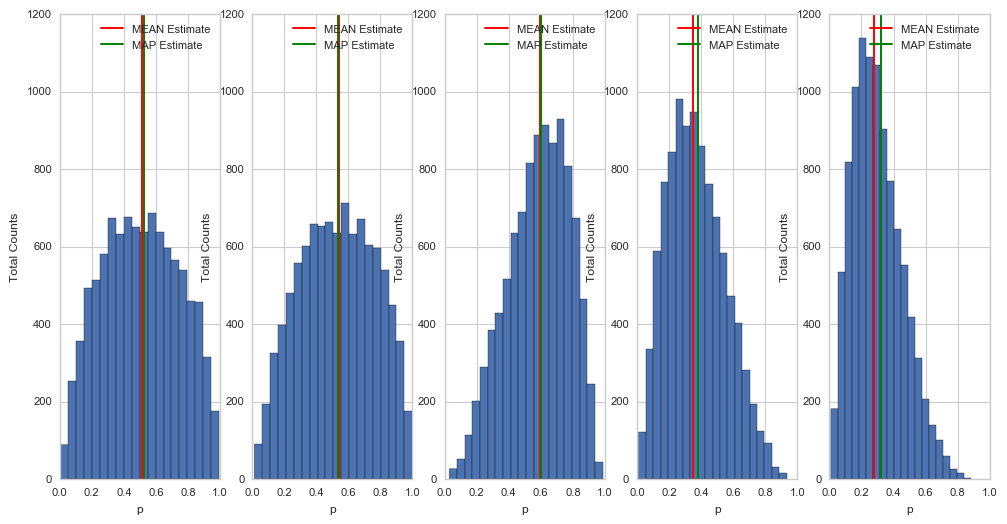

In [6]:
# generate the set of probabilities
invlogit = lambda X, betas: 1./(1.+np.exp(-X.dot(betas)) )
MAPProb = invlogit(X_train, mapEstimate)
MEAN_prob = invlogit(X_train, meanEstimate)
mapSubset = np.argsort(np.abs(np.array(MAPProb)-0.5))[:5]
meanSubset = np.argsort(np.abs(np.array(MEAN_prob)-0.5))[:5]

plt.figure(figsize=(12,6))
for inx, i in enumerate(mapSubset):
    plt.subplot(1, 5, inx+1)
    X = X_train[i,:]
    probabilities = trace['p'][:,i]
    plt.hist(probabilities, bins=20)
    plt.xlabel('p')
    plt.ylabel('Total Counts')
    plt.ylim((0, 1200))
    plt.xlim((0,1.0))
    plt.axvline(x=invlogit(X, meanEstimate), color='red', label='MEAN Estimate')
    plt.axvline(x=invlogit(X, mapEstimate), color='green', label='MAP Estimate')
    plt.legend(loc='best')

From the plots above, we can identify the uncertain points by looking at the training set samples that have MAP probabilities around 0.5. These points can either be classified as a 1 or 0, and therefore cannot be classfied with certainty.

---

Now that we have both point estimate(s) and a posterior distribution on the probability of a data point being virginica, we can use these to make predictions on both the training set and test set.

**There are two ways to make these predictions, given an estimate of $p(y=1 \vert x)$ **: 

(A) You can sample from the Bernoulli likelihood at the data point $x$ to decide if that particular data points classification $y(x)$ should be a 1 or a 0.

(B) Or you could do the intuitive "machine-learning-decision-theoretic" (MLDT) thing, where you assign a data  point $x$ a classification 1 if $p(y=1 \vert x) > 0.5$.

**And there are multiple ways in which you can do these probability estimates at a sample $x$**:

(A) You could just use the MAP value, ($p_{MAP}$), or the posterior mean ($p_{MEAN}$)

(B) You can see what fraction of your posterior samples have values above 0.5 (ie you are calculating 1-cdf(0.5)) on the posterior ($p_{CDF}$))

(C) Both these above methods miss the combined smearing of the posterior and sampling distributions. In other words they dont sample from the posterior predictive. If we draw a large number of samples from the posterior predictive distribution at a data point $x$, the fraction of 1s will give an estimate for the probability to use, $p_{PP}$, which is different from the MAP estimate, or the CDF estimate.

## Part B: Playing with Probabilities

1. Plot the distribution of $p_{MEAN}$, $p_{CDF}$, and $p_{PP}$ over all the data points in the training set. How are these different?
2. Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.
3. Make the same plot from the posterior, rather than the posterior predictive, by using the MLDT defined above. Overlay this plot on the previous one. That is, for every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Compare with your previous diagram. Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution? 
4. Is the classification at the true training data points (you can think of this as a bitstring '100101...' 90 characters long) represented in the posterior predictive trace? If so, how many times? Is it the most frequent string in the traces? Explain your conclusions.
5. Repeat 2 and 3 for the test set, i.e. make predictions. Describe and interpret the widths of the distributions?
 



# 1B (1) - Plot the distribution of  pMEAN, pCDF , and  pPP  over all the data points in the training set.

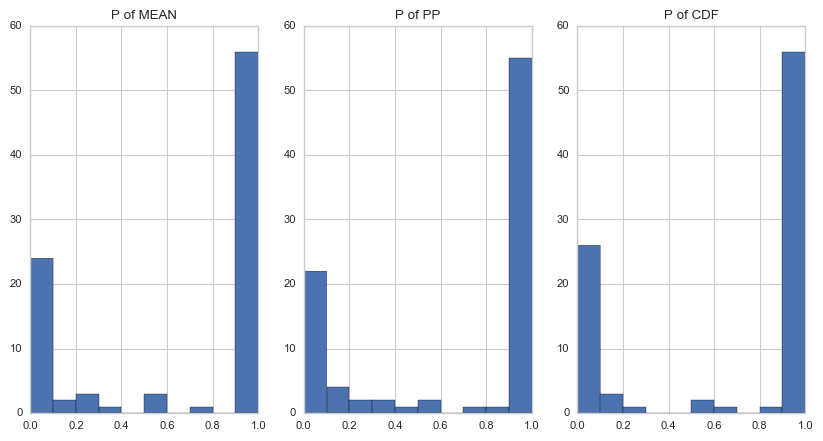

In [7]:
# calculate the p of MEAN
mean_probabilities = []
for i in range(X_train.shape[0]):
    X = X_train[i,:]
    mean_probabilities.append(invlogit(X, meanEstimate))
    
# calculate the p of CDF
pcdf = np.mean(trace['p']>0.5,axis=0)

# calculate the p of PP
pp_probabilities = []
for i in range(X_train.shape[0]):
    ps = trace['p'][:,i]
    pp_samples = stats.bernoulli.rvs(ps)
    pp_probabilities.append(pp_samples.mean())
    
# Plot the distribution of pMEAN, pCDF , and pPP over all the data points in the training set.
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.hist(mean_probabilities, bins=10)
plt.title('P of MEAN')
plt.subplot(1,3,2)
plt.hist(pp_probabilities, bins=10)
plt.title('P of PP')
plt.subplot(1,3,3)
plt.hist(pcdf, bins=10)
plt.title('P of CDF')

The pPP distribution displays a slightly higher density in the middle section while the pCDF and pMEAN both have a little higher densities near the edges.

# 1B (2) - Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities  y(x)  of the data points  x  (in other words you are plotting a histogram with the misclassification rate for the  ntrace  posterior-predictive samples) on the training set.


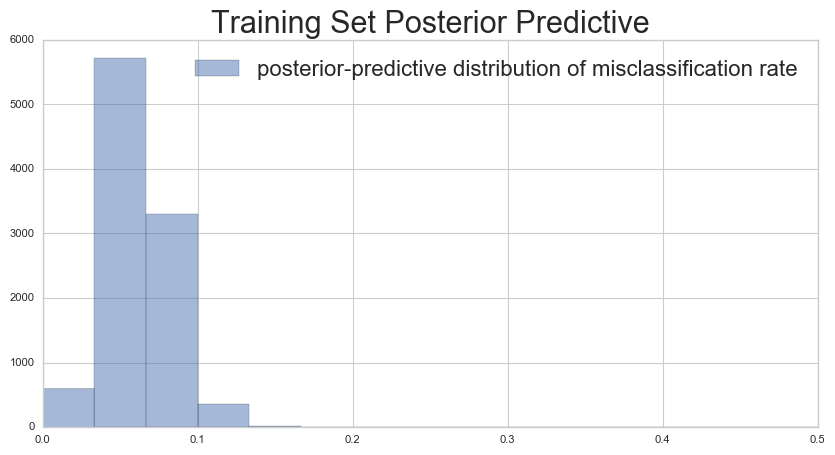

In [8]:
# calculate the posterior predictive misclassification rate
y_sample = stats.bernoulli.rvs(trace['p'])
misclassification_rates_posterior_predictive = []
for i in range(y_sample.shape[0]):
    compare = y_sample[i,:] != y_train
    misclassification_rates_posterior_predictive.append(compare.mean())
    
# using the posterior predictive misclassification rate, define the MLDT misclassification rate
score = np.apply_along_axis(lambda x: x > 0.5, 0, trace['p'])
misclassification_rates_posterior = []
for i in range(y_sample.shape[0]):
    compare = score[i,:]*1 != y_train
    misclassification_rates_posterior.append(compare.mean())

# Plot the posterior-predictive distribution of the misclassification rate 
# with respect to the true class identities y(x) of the data points x 
plt.figure(figsize=(10,5))
plt.title('Training Set Posterior Predictive', fontsize=22)
plt.hist(misclassification_rates_posterior_predictive, alpha=0.5,bins=15, label='posterior-predictive distribution of misclassification rate')
plt.legend(loc='best', fontsize=16)

# 1B (3) - Make the same plot from the posterior, rather than the posterior predictive, by using the MLDT defined above. Overlay this plot on the previous one. That is, for every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the  p>0.5⟹y=1  decision theoretic prespective. Compare with your previous diagram. Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution?

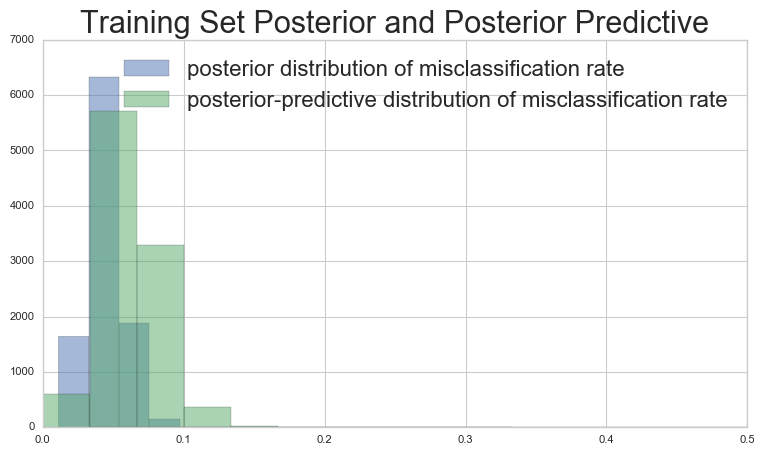

In [9]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Training Set Posterior and Posterior Predictive', fontsize=22)
plt.hist(misclassification_rates_posterior, bins=15, alpha=0.5, label='posterior distribution of misclassification rate')
plt.hist(misclassification_rates_posterior_predictive, alpha=0.5,bins=15, label='posterior-predictive distribution of misclassification rate')
plt.legend(loc='best', fontsize=16)

# Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution?



The posterior-predictive has a wider and flatter misclassification distribution. That being said, the posterior has a higher peak and narrower distribution.

# 1B (4) - Is the classification at the true training data points (you can think of this as a bitstring '100101...' 90 characters long) represented in the posterior predictive trace? If so, how many times? Is it the most frequent string in the traces? Explain your conclusions.

In [10]:
trace_results = {}
for i in range(np.shape(y_sample)[0]):
    sample = ''.join([str(e) for e in list(y_sample[i, :])])
    bitstring = ''.join(sample)
    if bitstring not in trace_results:
        trace_results[bitstring] = 1
    else:
        trace_results[bitstring] += 1
y_train_bitstring = ''.join([str(int(e)) for e in list(y_train)])

print("\n")
print ("For the Posterior Predictive:")
print('Num. of correct trace classifications: ', trace_results[y_train_bitstring])
print("\n")

score = score *1
trace_results_posterior = {}
for i in range(np.shape(y_sample)[0]):
    sample = ''.join([str(e) for e in list(score[i, :])])
    bitstring = ''.join(sample)
    if bitstring not in trace_results_posterior:
        trace_results_posterior[bitstring] = 1
    else:
        trace_results_posterior[bitstring] += 1
y_train_bitstring = ''.join([str(int(e)) for e in list(y_train)])
try:
    successes = trace_results_posterior[y_train_bitstring]
except KeyError:
    successes = 0
    
print ("For the posterior:")
print('Num. of correct trace classifications: ', successes)



For the Posterior Predictive:
Num. of correct trace classifications:  4


For the posterior:
Num. of correct trace classifications:  0


In [11]:
posterior_sorted = sorted(trace_results_posterior.items(), key=lambda x: x[1], reverse=True)
posterior_predictive_sorted = sorted(trace_results.items(), key=lambda x: x[1],reverse=True)

print ("\n")
print ("Posterior Traces Bitstring:")
print (posterior_sorted[:2])
print ("\n")
print ("Posterior Predictive Traces Bitstring:")
print (posterior_predictive_sorted[:3])



Posterior Traces Bitstring:
[('111010111111100101111111100101111011000110110111101110111010110111111000001101001111000110', 1044), ('111010111111000101111111100101110011000110110111101111111010110111111000001101001111000110', 702)]


Posterior Predictive Traces Bitstring:
[('111010111111000101111111100101110011000110110111101110111010110111111000001101001111000110', 97), ('111010111111100101111111100101111011000110110111101110111010110111111000001101001111000110', 97), ('111010111111000101111111100101110011000110110111101111111010110111111000001101001111000110', 87)]


# 1B (4) - If so, how many times? Is it the most frequent string in the traces? Explain your conclusions.

For the posterior predictive probabilities, the number of correct classifications was 4 while there were no correct classifications using the posterior probabilities. The posterior dislpays a more peaked distribution with the distribution of trace outcomes appearing to be in a more narrow range. The most frequent bitstrings account for approx. 10% of the dist. of trace outcomes in the posterior. The posterior predictive, on the other hand, has the most frequent traces occurring in larger counts with a flatter dist. and the most frequent bistrrings accounting for only approx. 1% of the dist. of trace outcomes.

# 1B (5) - Repeat 2 and 3 for the test set, i.e. make predictions. Describe and interpret the widths of the distributions?

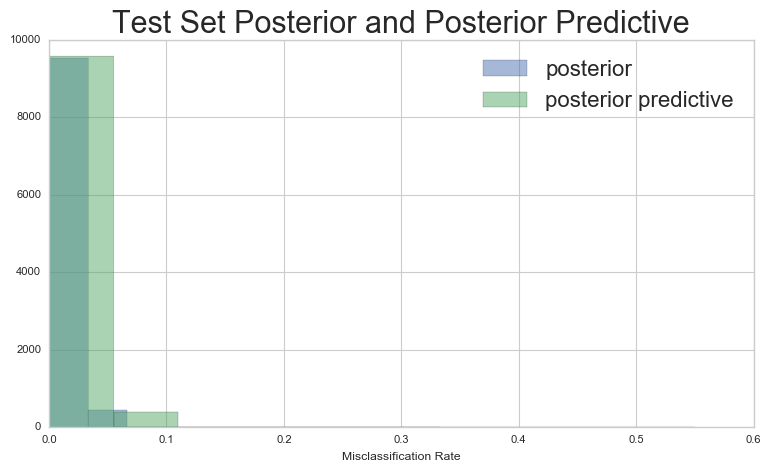

In [14]:
# calculate the posterior probabilities for the test set
n_test = X_test.shape[0]
p_test = np.zeros((10000, n_test))

for i in range(n_test):
    for j, bta in enumerate(trace['beta']):
        p_test[j, i] = invlogit(X_test[i,:], bta)
        
# calculate the posterior predictive misclassification rate
y_sample_test_set = stats.bernoulli.rvs(p_test)
misclassification_rates_posterior_predictive_test_set = []
for i in range(y_sample.shape[0]):
    compare = y_sample_test_set[i,:] != y_test
    misclassification_rates_posterior_predictive_test_set.append(compare.mean())
    
# using the posterior predictive misclassification rate, define the MLDT misclassification rate
score_test_set = np.apply_along_axis(lambda x: x > 0.5, 0, p_test)
misclassification_rates_posterior_test_set = []
for i in range(y_sample.shape[0]):
    compare = score_test_set[i,:]*1 != y_test
    misclassification_rates_posterior_test_set.append(compare.mean())

# Plot the posterior-predictive distribution of the misclassification rate 
# with respect to the true class identities y(x) of the data points x 
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Test Set Posterior and Posterior Predictive', fontsize=22)
plt.xlabel('Misclassification Rate')
plt.hist(misclassification_rates_posterior_test_set, alpha = 0.5, bins=10, label='posterior')
plt.hist(misclassification_rates_posterior_predictive_test_set,  alpha = 0.5,bins=10, label='posterior predictive')
plt.legend(loc='best', fontsize=16)

# Describe and interpret the widths of the distributions:

The width of the posterior predictive distribution is wider than that of the posterior distribution.  This shows a higher misclassification rate (though still small) in the posterior predictive distribution.  We learned that predictive distribution is based on what we hae learned from the Iris dataset - and therefore there exists a greater degree of uncertainty in the posterior distribution.  Since there is uncertainty about the true success probability, or how an observation may deviate from its expected value in the predictie distribution (although not in the posterior distribution which was given to us), a wider distribution of misclassification rate is expected here.

## Extra Credit: Deriving the MLDT

If you took a distribution of prediction to your boss, he/she would probably ask you to make a choice. Decision Theory is the right way to make such a choice, rather than choosing an arbitrary set of bernoulli samplings. The idea is to minimize the posterior predictive averaged decision risk at each sample $x$:

$$R(g, x) = \int dy P(y \vert x) R(g, y \vert x) = \sum_{y=0,1} P(y \vert x) R(g, y \vert x)$$

where $g$ is the action you take: classify as 1 or 0. Use $R(g, y \vert x) = {\mathbb 1}_{g \ne y} \forall x$, the 1-0 loss.

1. Show that if $R(1, x) <= R(0, x)$ and thus we choose 1 as our classification, $p(1 \vert x) >= 0.5$. 
2. Use this MLDT rule and probabilities from both $p_{CDF}$ and $p_{PP}$ to make two classifications on the training set and test set. What is the misclassification rate in both? WHy do you think this is the case? 

# Extra Credit (1) - Show that if  R(1,x)<=R(0,x) and thus we choose 1 as our classification,  p(1|x)>=0.5 .

$$\begin{aligned}
R(0, x) = P(0|x)R(0, 0|x) + P(1|x)R(0, 1|x)\\ 
    \newline
R(1, x) = P(0|x)R(1, 0|x) + P(1|x)R(1, 1|x)
\end{aligned}$$
This can be simplified because R is a 1-0 loss:
$$\begin{aligned}
R(0, x) = P(1|x)\\ 
    \newline
R(1, x) = P(0|x)
\end{aligned}$$
Because $R(1, x) <= R(0, x)$, we can substitute the following for $P$:
$$ P(0|x) <= P(1|x)$$
Since we know $ P(0|x) + P(1|x) = 1 $, we can deduce the following:
$$p(1 \vert x) >= 0.5$$

# Extra Credit (2) - Use this MLDT rule and probabilities from both  pCDF  and  pPP  to make two classifications on the training set and test set.

In [13]:
# get the pCDF training set predictions
pcdf_train_set_predictions = pcdf>0.5
pcdf_train_set_predictions = pcdf_train_set_predictions*1

# get the posterior probabilities for the test set 
n_test = X_test.shape[0]
p_test = np.zeros((10000, n_test))

for i in range(n_test):
    for j, bta in enumerate(trace['beta']):
        p_test[j, i] = invlogit(X_test[i,:], bta)
        
pcdf_test_set = np.mean(p_test>0.5,axis=0)
pcdf_test_predictions = pcdf_test_set>0.5
pcdf_test_predictions = pcdf_test_predictions*1

# get the pPP probabilities for the training set
pp_probabilities = []
for i in range(X_train.shape[0]):
    ps = trace['p'][:,i]
    pp_samples = stats.bernoulli.rvs(ps)
    pp_probabilities.append(pp_samples.mean())
pp_probabilities = np.array(pp_probabilities)

# get the pPP probabilities for the test set
pp_probabilities_test_set = []
for i in range(X_test.shape[0]):
    ps = p_test[:,i]
    pp_samples_test = stats.bernoulli.rvs(ps)
    pp_probabilities_test_set.append(pp_samples_test.mean())
pp_probabilities_test_set = np.array(pp_probabilities_test_set)

misclassification_rates_train_set = np.mean(pcdf_train_set_predictions != y_train)
print('Training Set pCDF Misclassification rate:', misclassification_rates_train_set)

misclassification_rates_test = np.mean(pcdf_test_predictions != y_test)
print('Test Set pCDF Misclassification rate: ', misclassification_rates_test)

pp_probabilities_preds_train_set = pp_probabilities>0.5
pp_probabilities_preds_train_set = pp_probabilities_preds_train_set*1
misclassification_rates_train_set_pp = np.mean(pp_probabilities_preds_train_set != y_train)
print ("\n")
print('Training Set pPP Misclassification rate: ', misclassification_rates_train_set_pp)

pp_probabilities_preds_test = pp_probabilities_test_set>0.5
pp_probabilities_preds_test = pp_probabilities_preds_test*1
misclassification_rates_test_pp = np.mean(pp_probabilities_preds_test != y_test)
print('Test Set pPP Misclassification rate: ', misclassification_rates_test_pp)

Training Set pCDF Misclassification rate: 0.0222222222222
Test Set pCDF Misclassification rate:  0.0


Training Set pPP Misclassification rate:  0.0222222222222
Test Set pPP Misclassification rate:  0.0


#  Extra Credit (2) - What is the misclassification rate in both? WHy do you think this is the case?

The posterior and posterior predictive misclassification rates are very similar in both the test set and the training set, at 0 and 0.0222, respectively. Also, the posterior and posterior predictive misclassification rates are identical for the test set.  Note that the misclassification rates are very low for the training set, and is 0 for the test set, which is unexpected. 

Because of the output probabilities from both pCDF and pPP are very similar, we would expect that the misclassification rates are also similar. 